# Predictive Analysis of Hotel Booking Cancellation
---
By [Cindy Fransisca](www.linkedin.com/in/cindy-fransisca-18ba81213)

## Business Problem Understanding
---

**Introduction**

Booking cancellations have a significant impact in the hospitality industry. Some hotels use the overbooking strategy to avoid booking cancellation problems. The overbooking strategy can help maximizing the revenue but might also give a negative impact on reputation if the hotel is actually overbooked. Predicting the hotel booking cancellations can help the hotel businesses improve their overbooking strategy and minimize their risk.

**Target** :
- 1 : Cancelled Booking
- 0 : Non-Cancelled Booking




**Problem Statement :**

The overbooking strategy will perform well if we know the number of bookings that will be cancelled by the customers. If the assumed number of cancelled bookings is too small, then we will be left with a lot of empty rooms. If the assumed number of cancelled bookings is too big, then we will have a lot of upset customers who don't get rooms. 


**Goals :**

Based on the problems we have, we want to detect which bookings will be cancelled or not. This way we can make better decisions on the overbooking strategy. We might also find which characteristics resulting in cancelled bookings, so it will help us identify the cancelled bookings better.


**Analytic Approach :**

We will analyze the data to find the characteristics of cancelled bookings. After that, we will build a classification model to help predicting the number of cancelled bookings.

**Evaluation Metric**

Type 1 error : False Positive  
cons: Rooms will be overbooked, and customers will be disappointed (no longer book the hotel)

Type 2 error : False Negative  
cons: Rooms are empty, even though there might be potential customers who want to stay at the hotel

Both cases will have negative impacts on the revenue, but the overbooked cases are worse because they can cause potential loss of future revenue from discontent customers who will no longer book the hotel. In this case our positive target is more important than the negative class. We might also put more weight on precision to avoid a lot of upset customers. So, the main metric that will be used is f0.5-score.


## Data Understanding

Dataset source : https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand

Note : 
- Target is imbalance in the dataset
- Each row represents informations of a booking which is made by past customers.

### Attribute Information

| Attribute | Description |
| --- | --- |
| country | Country of origin. Categories are represented in the ISO 3155–3:2013 format. |
| market_segment | Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators”. |
| previous_cancellations | Number of previous bookings that were cancelled by the customer prior to the current booking. |
| booking_changes | Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation. |
| deposit_type | Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories: No Deposit – no deposit was made; Non Refund – a deposit was made in the value of the total stay cost; Refundable – a deposit was made with a value under the total cost of stay. |
| days_in_waiting_list | Number of days the booking was in the waiting list before it was confirmed to the customer. |
| customer_type | Type of booking, assuming one of four categories: Contract - when the booking has an allotment or other type of contract associated to it; Group – when the booking is associated to a group; Transient – when the booking is not part of a group or contract, and is not associated to other transient booking; Transient-party – when the booking is transient, but is associated to at least other transient booking. |
| reserved_room_type | Code of room type reserved. Code is presented instead of designation for anonymity reasons. |
| required_car_parking_spaces | Number of car parking spaces required by the customer. |
| total_of_special_requests | Number of special requests made by the customer (e.g. twin bed or high floor). |
| is_canceled | Value indicating if the booking was canceled (1) or not (0). |

## Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import time

# traintest split
from sklearn.model_selection import train_test_split

# Preprocessing
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline

#feature selection
from sklearn.feature_selection import SelectPercentile, SelectFromModel

# ML algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb


# Evaluation
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, fbeta_score, make_scorer
from sklearn.metrics import  classification_report, confusion_matrix, PrecisionRecallDisplay, ConfusionMatrixDisplay


#Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
pd.set_option('display.max_colwidth', None)

## Explore The Data

In [3]:
raw_data = pd.read_csv('data_hotel_booking_demand.csv')
df = raw_data.copy()
df.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


In [5]:
df.describe(include='all')

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
count,83222,83573,83573.000000,83573.000000,83573,83573.000000,83573,83573,83573.000000,83573.000000,83573.000000
unique,162,8,NaN,NaN,3,NaN,4,10,NaN,NaN,NaN
top,PRT,Online TA,NaN,NaN,No Deposit,NaN,Transient,A,NaN,NaN,NaN
freq,34097,39460,NaN,NaN,73352,NaN,62732,60041,NaN,NaN,NaN
mean,NaN,NaN,0.086798,0.220897,NaN,2.330561,NaN,NaN,0.062999,0.573211,0.368277
std,NaN,NaN,0.841011,0.648635,NaN,17.673051,NaN,NaN,0.246919,0.795163,0.482340
min,NaN,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000
50%,NaN,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000
75%,NaN,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,1.000000,1.000000


In [6]:
listItem = []
for col in df.columns :
    listItem.append( [col, df[col].nunique(), df[col].unique()])

unique_values = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=listItem)
unique_values

,Column Name,Number of Unique,Unique Sample
0,country,162,"[IRL, FRA, PRT, NLD, ESP, UMI, CN, LUX, BRA, BEL, JPN, DEU, ITA, CHE, GBR, AGO, SRB, COL, CHN, SWE, AUT, CIV, CZE, POL, USA, SGP, RUS, ROU, DNK, IND, MAR, PHL, ARG, ISL, ZAF, LBN, MOZ, TUR, BGD, MEX, CAF, NOR, FIN, UKR, EGY, ISR, nan, KOR, AZE, HUN, AUS, EST, CHL, SVN, PRY, ABW, ALB, LTU, ARE, HRV, SAU, NZL, LVA, ATA, KAZ, DZA, TWN, CRI, BIH, BGR, IRQ, OMN, VEN, IDN, GEO, MLT, IRN, BLR, URY, LBY, TUN, BEN, MYS, MWI, GRC, CYP, CPV, HKG, PRI, MKD, MUS, IMN, PAN, NGA, GLP, KHM, PER, QAT, SEN, MAC, ...]"
1,market_segment,8,"[Offline TA/TO, Online TA, Direct, Groups, Corporate, Complementary, Aviation, Undefined]"
2,previous_cancellations,15,"[0, 1, 25, 2, 3, 11, 24, 13, 6, 26, 14, 4, 19, 5, 21]"
3,booking_changes,19,"[0, 1, 2, 5, 3, 4, 6, 7, 9, 8, 17, 10, 13, 12, 14, 21, 16, 20, 15]"
4,deposit_type,3,"[No Deposit, Non Refund, Refundable]"
5,days_in_waiting_list,115,"[0, 3, 39, 87, 77, 215, 97, 162, 46, 79, 4, 31, 122, 34, 57, 259, 50, 17, 32, 43, 75, 69, 44, 22, 113, 58, 38, 65, 48, 236, 176, 25, 108, 91, 19, 160, 68, 28, 63, 35, 42, 59, 24, 8, 183, 187, 21, 111, 56, 98, 101, 15, 16, 47, 93, 45, 14, 70, 10, 49, 178, 99, 60, 40, 85, 223, 6, 33, 391, 20, 1, 41, 147, 55, 80, 379, 150, 61, 330, 174, 107, 96, 18, 62, 13, 30, 120, 27, 207, 71, 2, 76, 125, 5, 9, 224, 53, 83, 84, 12, ...]"
6,customer_type,4,"[Transient-Party, Transient, Contract, Group]"
7,reserved_room_type,10,"[A, E, D, F, B, G, C, H, L, P]"
8,required_car_parking_spaces,5,"[0, 1, 2, 8, 3]"
9,total_of_special_requests,6,"[0, 2, 1, 3, 4, 5]"


### Missing Values

In [7]:
def missing_values(df):
    missing_values = df.isnull().sum().to_frame().reset_index()
    missing_values = missing_values.rename(columns = {'index': 'column', 0: 'number of missing values'})
    missing_values['% missing values'] = (missing_values['number of missing values']/df.shape[0]*100).round(2)
    
    return missing_values


In [8]:
missing_values(df)

,column,number of missing values,% missing values
0,country,351,0.42
1,market_segment,0,0.00
2,previous_cancellations,0,0.00
3,booking_changes,0,0.00
4,deposit_type,0,0.00
5,days_in_waiting_list,0,0.00
6,customer_type,0,0.00
7,reserved_room_type,0,0.00
8,required_car_parking_spaces,0,0.00
9,total_of_special_requests,0,0.00


There are some missing values in the `country` column. The number is quite small, so we can drop them or fill them with 'Other'. We will decide later on the preprocessing step.

### Duplicates

In [9]:
duplicates = df.duplicated().sum()

print('Number of duplicates =', duplicates)

Number of duplicates = 73371


In [10]:
percent_duplicates = df.duplicated().sum()/len(df)*100

print('Percent of duplicates =', percent_duplicates)

Percent of duplicates = 87.79270817129934


In [11]:
df[df.duplicated()]

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
7,PRT,Groups,0,0,Non Refund,0,Transient,A,0,0,1
22,PRT,Groups,0,0,Non Refund,0,Transient,A,0,0,1
29,PRT,Online TA,0,0,No Deposit,0,Transient,A,0,1,0
34,PRT,Groups,0,0,Non Refund,0,Transient,A,0,0,1
44,PRT,Groups,0,0,Non Refund,0,Transient,A,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
83568,PRT,Online TA,0,0,No Deposit,0,Contract,A,0,3,1
83569,FRA,Online TA,0,0,No Deposit,0,Transient,D,0,2,0
83570,PRT,Online TA,0,1,No Deposit,0,Transient,D,0,3,0
83571,CN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0


There are 87.79% duplicates in our data. Since each row represents a booking, it's natural if a booking happens to have the same details with another booking. Because we don't have information about the booking ID to identify wheter a booking is duplicated or not, we just assume that our data has no duplicate bookings. So, we will leave the duplicates in our data and use them for modeling.

## EDA

In [12]:
categorical_cols = list(df.select_dtypes(['object','category']).columns)
numerical_cols = list(set(df.drop('is_canceled', axis=1).columns)-set(categorical_cols))

### Number of bookings which are canceled

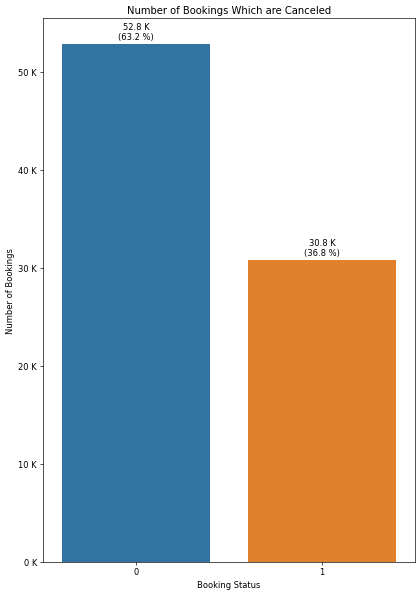

In [13]:
plt.figure(figsize=(8,12), dpi=60)
fig = sns.countplot(data= df, x = 'is_canceled', order=df['is_canceled'].value_counts().index)

percentage = df['is_canceled'].value_counts()/len(df)*100
label = ['{:,.1f} K\n({:.1f} %)'.format(x, y) for x, y in zip(fig.containers[0].datavalues/1000,percentage)]
fig.bar_label(fig.containers[0], labels=label, padding=3)

ytick_label = ['{:,.0f} K'.format(x) for x in (fig.get_yticks()[:-1]/1000)]
fig.set_yticks(range(0, 50001, 10000))
fig.set_yticklabels(ytick_label)

plt.ylabel('Number of Bookings')
plt.xlabel('Booking Status')
plt.title('Number of Bookings Which are Canceled')

plt.show()

We can see that our data has **imbalance target**. The figure shows that **63.2%** of the bookings are **not canceled** and **36.8%** of the bookings are **canceled**.

### Data Distribution

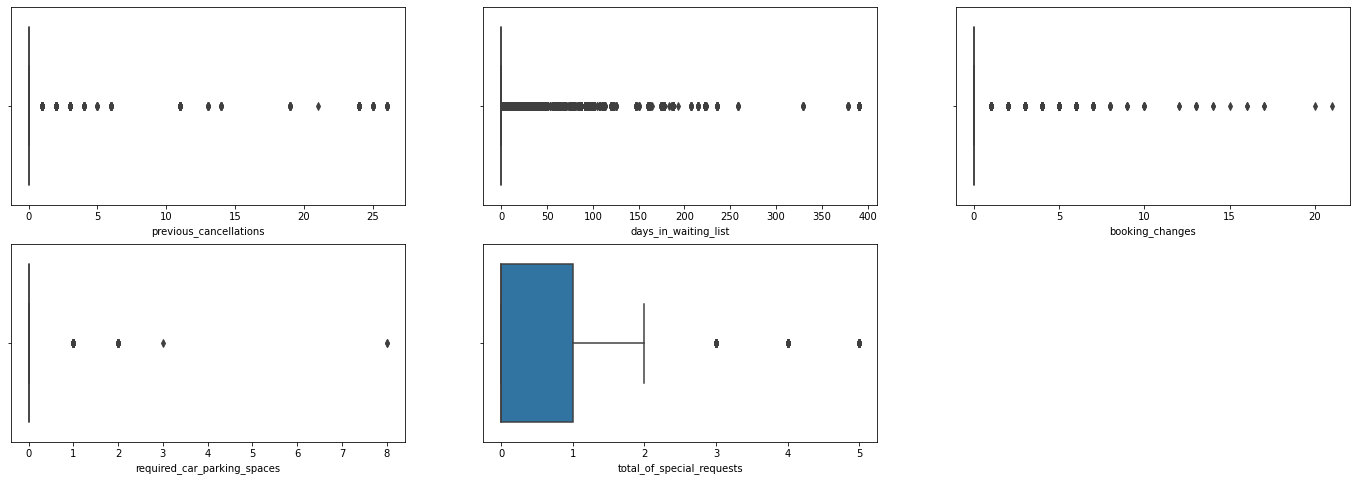

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(24,8))

for i, j in zip(numerical_cols, axes.flatten()):
    sns.boxplot(data=df, x= i, ax= j)

plt.gca().axis('off')

plt.show()

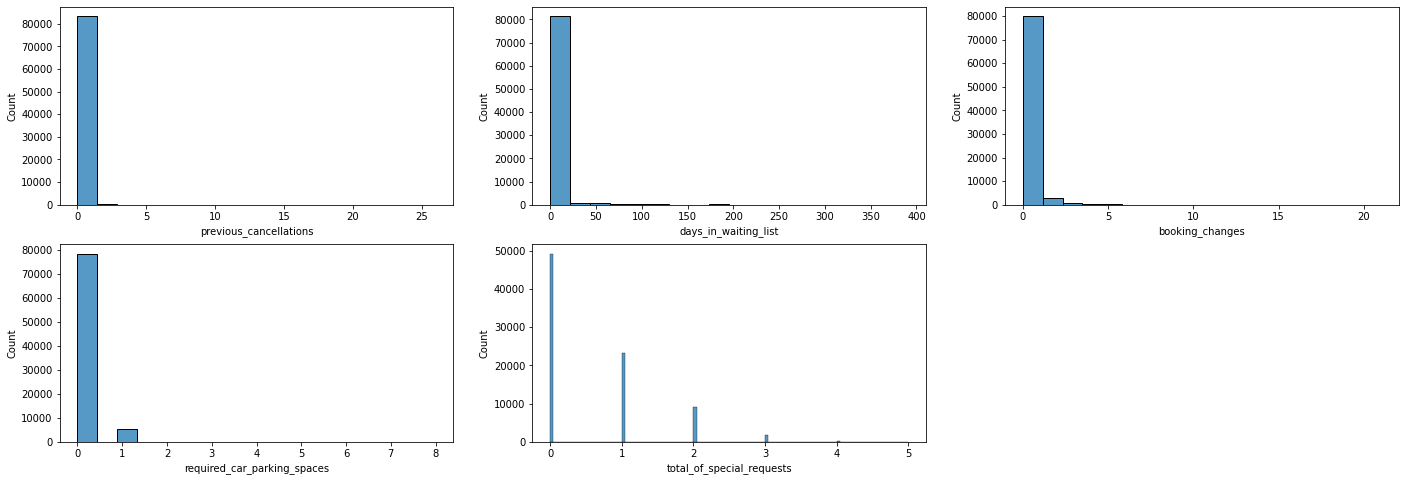

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(24,8))

for i, j in zip(numerical_cols, axes.flatten()):
    sns.histplot(data=df, x= i, ax= j)

plt.gca().axis('off')

plt.show()

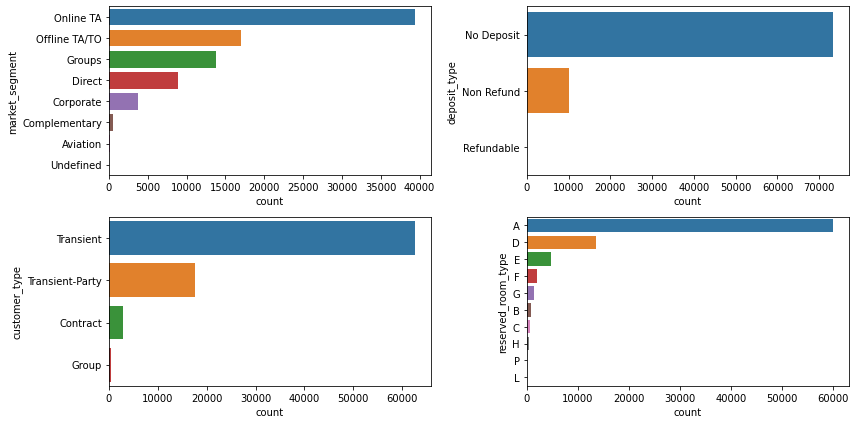

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

for i, j in zip([cols for cols in categorical_cols if cols != 'country'], axes.flatten()):
    sns.countplot(data=df, y= i, ax= j, order=df[i].value_counts().index)


plt.tight_layout()
plt.show()


In [17]:
top10_country = df['country'].value_counts().to_frame().reset_index().head(10)
top10_country = top10_country.rename(columns={'country':'Number of Bookings', 'index': 'Country'})
top10_country

,Country,Number of Bookings
0,PRT,34097
1,GBR,8495
2,FRA,7307
3,ESP,5996
4,DEU,5116
5,ITA,2658
6,IRL,2340
7,BEL,1648
8,BRA,1553
9,USA,1472


<AxesSubplot:xlabel='Country', ylabel='Number of Bookings'>

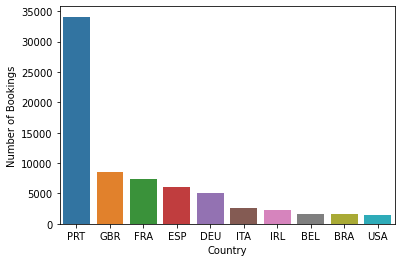

In [18]:
sns.barplot(data = top10_country, x='Country', y='Number of Bookings')

**Summary**:
- Most of the bookings have **no** special request, booking changes, or previous cancellations. They also spend **no** days in waiting list and **don't** require car parking spaces.
- The biggest market segment comes from **online travel agency** and the customer type is **transient**.
- The bookings mostly reserve **room type A** and require **no deposit**.
- The top 5 countries of the bookings come from **Europe** with **Portugal** as the most common one.

### Bivariate Analysis

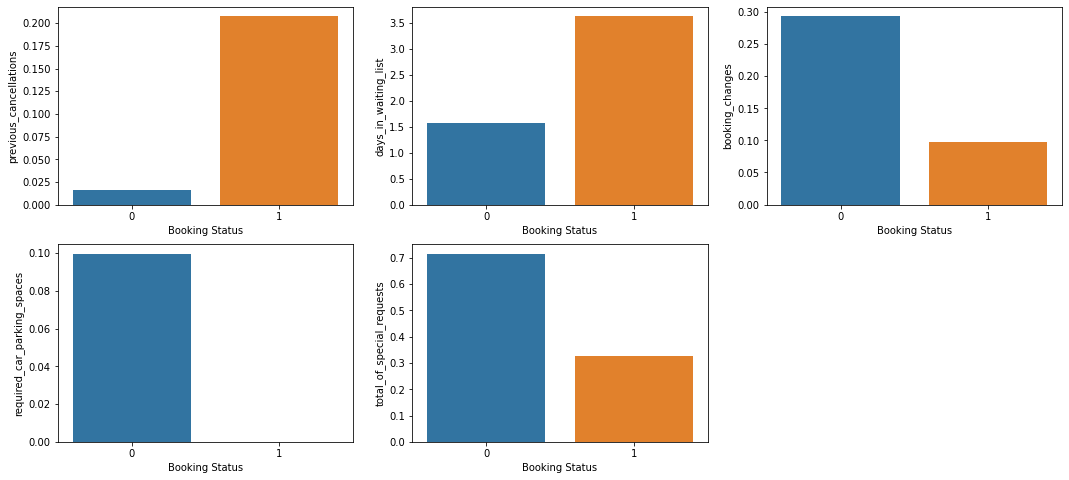

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

for i, j in zip(numerical_cols, axes.flatten()):
    graph = sns.barplot(data=df, x= 'is_canceled', y= i , ax= j, ci=0)
    graph.set_xlabel('Booking Status')

plt.gca().axis('off')
plt.show()

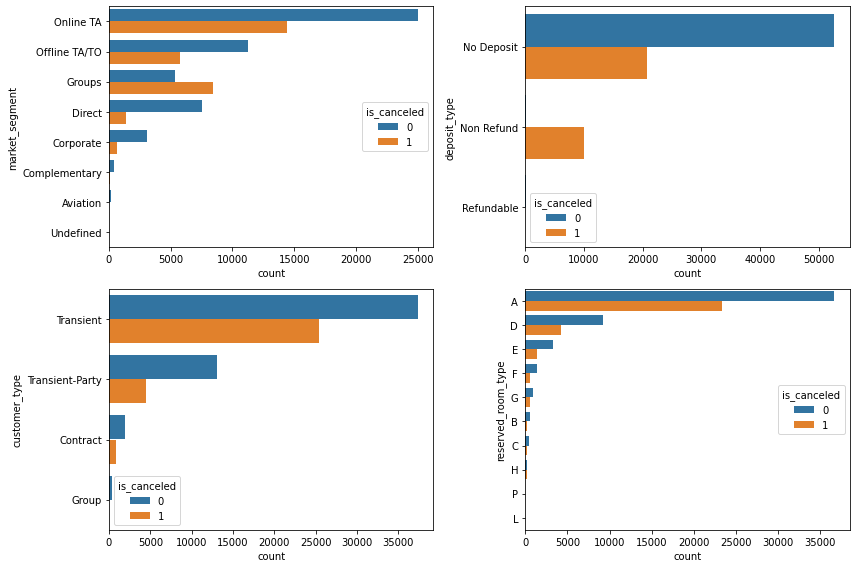

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, j in zip([cols for cols in categorical_cols if cols != 'country'], axes.flatten()):
    sns.countplot(data=df, y= i, ax= j, hue='is_canceled', order=df[i].value_counts().index)

plt.tight_layout()
plt.show()


<AxesSubplot:xlabel='count', ylabel='country'>

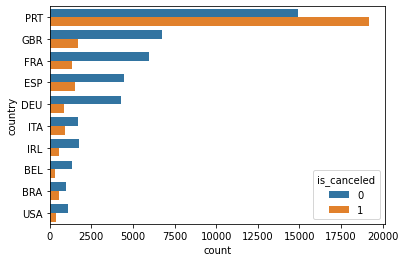

In [21]:
df_country = df[df['country'].isin(top10_country['Country'])]

sns.countplot(data=df_country, y= 'country', hue='is_canceled', order= df_country['country'].value_counts().index)


<AxesSubplot:title={'center':'Correlation Matrix'}>

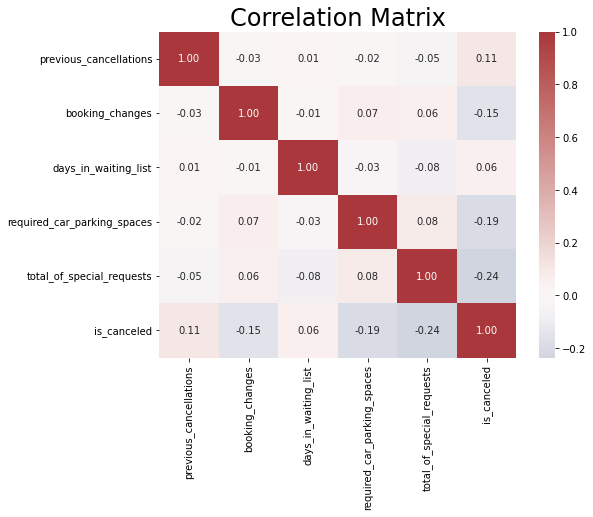

In [22]:
plt.figure(figsize=(8,6))
plt.title('Correlation Matrix', fontsize=24)
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap= 'vlag', center=0)

**Summary**:
- The canceled bookings tend to have **higher** days in waiting list and previous cancellations.
- The **group** market segment has the highest proportion of canceled bookings 
- The **non refund** bookings also have the highest proportion of canceled bookings.
- Most of the canceled bookings come from **Portugal**.
- The canceled bookings have a **weak correlation** with number of special requests.

### Multivariate Analysis

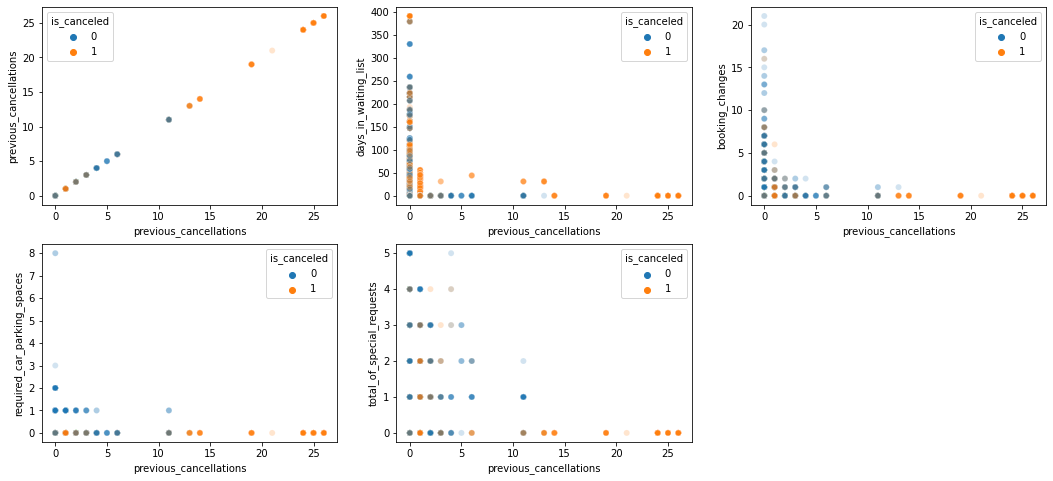

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

for i, j in zip(numerical_cols, axes.flatten()):
    graph = sns.scatterplot(data=df, x='previous_cancellations', y= i, hue='is_canceled', alpha=0.2 , ax= j)

plt.gca().axis('off')
plt.show()

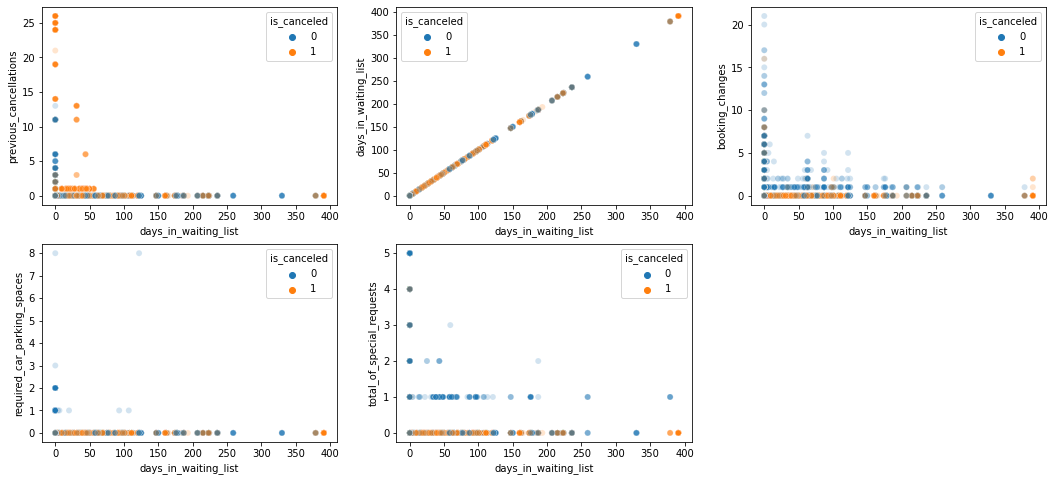

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

for i, j in zip(numerical_cols, axes.flatten()):
    graph = sns.scatterplot(data=df, x='days_in_waiting_list', y= i, hue='is_canceled', alpha=0.2, ax= j)

plt.gca().axis('off')
plt.show()

From the graph, we can not really see any obvious pattern in our data. So, we will just move on to the next step.

## Handling Outliers

Because we don't have enough domain knowledge to identify the outliers in our data, we will not do anything to the outliers.

## Define features

We will use all the columns for our features. We don't do feature selection because we don't have many columns from the beginning.

In [25]:
X = df.drop('is_canceled', axis=1)
y = df['is_canceled']

## Data Splitting

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

## Preprocessing

We will do several steps for our preprocessing:
- Impute missing values
    - `country`: constant (Other)
        <br>
        We will fill the missing values in the `country` column with 'Other' because we can't guess where the bookings come from. So, it will make more sense to fill them with 'Other'.
- Encoding
    - `country`: binary encoding
       <br>
        We will use binary encoding for the `country` column because it has a large number of uniques
    - `market_segment`, `deposit_type`, `customer_type`, `reserved_room_type` : one-hot encoding
      <br>
        For the other category columns, we will use one-hot encoding because the data is nominal not ordinal and they don't have large number of uniques.  
- Scaling : Robust Scaler
   <br>
    We use Robust Scaler because our data has outliers and Robust Scaler won't be affected by outliers. We can tune the scaler later to find the best scaler.


In [27]:
imp_binary = Pipeline([
    ('constant', SimpleImputer(strategy='constant', fill_value='Other')),
    ('binary', ce.BinaryEncoder(handle_unknown='indicator'))
    ])

imp_binary

Pipeline(steps=[('constant',
                 SimpleImputer(fill_value='Other', strategy='constant')),
                ('binary', BinaryEncoder(handle_unknown='indicator'))])

In [28]:
transformer = ColumnTransformer([
    ('imp_binary', imp_binary, ['country']),
    ('one hot', OneHotEncoder(handle_unknown='infrequent_if_exist', min_frequency=6), [col for col in categorical_cols if col != 'country'])
], remainder = 'passthrough')

transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('imp_binary',
                                 Pipeline(steps=[('constant',
                                                  SimpleImputer(fill_value='Other',
                                                                strategy='constant')),
                                                 ('binary',
                                                  BinaryEncoder(handle_unknown='indicator'))]),
                                 ['country']),
                                ('one hot',
                                 OneHotEncoder(handle_unknown='infrequent_if_exist',
                                               min_frequency=6),
                                 ['market_segment', 'deposit_type',
                                  'customer_type', 'reserved_room_type'])])

In [29]:
scaler = RobustScaler()

## Benchmark Model

Model benchmarking is a method to evaluate and compare ML algorithms regarding their ability to learn the data. The metric that will be used to measure our models' performance is f0.5 score. This metric is chosen because the positive target is more important and we want to put more weight on precision. We will decide our best model base on the f0.5 score and its training time.

#### Models

In [30]:
logreg = LogisticRegression(random_state=0, solver='liblinear')
knn = KNeighborsClassifier(n_neighbors=5)
dtree = DecisionTreeClassifier(random_state=0, max_depth=5)
rf = RandomForestClassifier(random_state=0)
ada = AdaBoostClassifier(random_state=0)
gbm = GradientBoostingClassifier(random_state=0)
lgbm = lgb.LGBMClassifier()
xgboost = XGBClassifier()


models = [
    ('Logistic Regression', logreg), 
    ('KNN', knn),
    ('Decision Tree', dtree),
    ('Random Forest', rf), 
    ('AdaBoost', ada),
    ('Gradient Boosting', gbm),
    ('Light GBM', lgbm),
    ('Xgboost', xgboost)
    ]

In [31]:
scoring_f05 = make_scorer(fbeta_score, beta=0.5)

In [32]:
def cross_val(X_train, y_train, models, metric):

    list_name = []
    list_mean = []
    list_std = []
    cross_val = []
    list_fit_time = []
    list_score_time = []

    for name, model in models:
        pipe_model = Pipeline([
            ('preprocessing', transformer),
            ('scaler', scaler),
            ('algo', model)
        ])

        skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

        model_cv = cross_validate(
            estimator= pipe_model,
            X= X_train,
            y= y_train,
            cv= skfold,
            scoring= metric
        )

        if type(metric) == str:
            metric_name = metric
        else:
            metric_name = 'f0.5' 
        
        list_name.append(name)
        list_fit_time.append(round(model_cv['fit_time'].mean(), 3))
        list_score_time.append(round(model_cv['score_time'].mean(), 3))
        list_mean.append(round(model_cv['test_score'].mean(), 3))
        list_std.append(round(model_cv['test_score'].std(), 3))
        cross_val.append(np.round_(model_cv['test_score'],3))

    result = pd.DataFrame({
        'model' : list_name,
        f'mean {metric_name}' : list_mean,
        'std' : list_std,
        'fit time' : list_fit_time,
        'score time' : list_score_time,
        f'{metric_name}' : cross_val
    })    

    return result.sort_values(f'mean {metric_name}', ascending=False)

In [33]:
cross_val(X_train, y_train, models, scoring_f05)

,model,mean f0.5,std,fit time,score time,f0.5
7,Xgboost,0.759,0.003,2.748,0.096,"[0.763, 0.762, 0.758, 0.756, 0.756]"
5,Gradient Boosting,0.758,0.004,9.538,0.060,"[0.761, 0.759, 0.75, 0.759, 0.761]"
6,Light GBM,0.757,0.003,0.715,0.110,"[0.761, 0.76, 0.753, 0.756, 0.754]"
3,Random Forest,0.748,0.003,3.791,0.261,"[0.751, 0.751, 0.749, 0.743, 0.747]"
4,AdaBoost,0.743,0.005,2.970,0.181,"[0.748, 0.744, 0.736, 0.74, 0.75]"
2,Decision Tree,0.735,0.008,0.457,0.036,"[0.736, 0.732, 0.724, 0.748, 0.734]"
0,Logistic Regression,0.725,0.003,0.753,0.039,"[0.726, 0.721, 0.726, 0.721, 0.729]"
1,KNN,0.712,0.003,0.389,1.799,"[0.715, 0.708, 0.713, 0.709, 0.714]"


In [34]:
cross_val(X_train, y_train, models, 'precision')

,model,mean precision,std,fit time,score time,precision
4,AdaBoost,0.810,0.009,3.379,0.212,"[0.824, 0.807, 0.8, 0.804, 0.814]"
5,Gradient Boosting,0.809,0.007,9.656,0.057,"[0.815, 0.811, 0.798, 0.803, 0.816]"
0,Logistic Regression,0.783,0.008,0.688,0.036,"[0.784, 0.774, 0.795, 0.775, 0.788]"
7,Xgboost,0.781,0.010,2.922,0.101,"[0.799, 0.779, 0.782, 0.77, 0.774]"
6,Light GBM,0.774,0.005,0.697,0.110,"[0.784, 0.775, 0.773, 0.77, 0.771]"
2,Decision Tree,0.768,0.010,0.480,0.036,"[0.77, 0.761, 0.756, 0.785, 0.767]"
3,Random Forest,0.763,0.009,3.850,0.264,"[0.777, 0.763, 0.766, 0.75, 0.76]"
1,KNN,0.725,0.004,0.339,1.802,"[0.723, 0.72, 0.732, 0.722, 0.726]"


In [35]:
cross_val(X_train, y_train, models, 'recall')

,model,mean recall,std,fit time,score time,recall
3,Random Forest,0.695,0.018,3.975,0.263,"[0.664, 0.708, 0.687, 0.715, 0.7]"
6,Light GBM,0.694,0.009,0.740,0.107,"[0.682, 0.703, 0.686, 0.706, 0.692]"
7,Xgboost,0.684,0.021,3.148,0.111,"[0.647, 0.7, 0.676, 0.705, 0.692]"
1,KNN,0.666,0.012,0.330,1.879,"[0.685, 0.663, 0.647, 0.662, 0.67]"
2,Decision Tree,0.628,0.004,0.442,0.035,"[0.627, 0.634, 0.621, 0.629, 0.627]"
5,Gradient Boosting,0.607,0.008,9.779,0.057,"[0.602, 0.604, 0.605, 0.622, 0.601]"
4,AdaBoost,0.560,0.009,3.175,0.184,"[0.544, 0.566, 0.556, 0.561, 0.571]"
0,Logistic Regression,0.558,0.009,0.677,0.034,"[0.56, 0.566, 0.539, 0.562, 0.56]"


If we look at the f0.5 score the top 3 algorithms are Xgboost, Gradient Boosting, and Light GBM. But, if we go deeper into the precision score, it turns out Adaboost has the highest score and Xgboost only rank 4th. So, why is Xgboost rank 1st in the f0.5 score? The answer is clear when we look into the recall score. Xgboost has quite big difference in recall score with Adaboost. The difference in precision score between Xgboost and Adaboost is much smaller than the difference in recall score. Although, f0.5 score put more weight on precision score, but it also put recall score into consideration. This is also why we chose f.05 score as our main metric. If we chose precision as our metric, we might think Adaboost is our best algorithm. But it turns out its recall score is pretty bad. We want to quite balance it out, so the algorithm will have a good precision score and also pretty decent recall score.


Next, we will look into the training time (fit time) of the top 3 algorithms. The top 3 algorithms have a really close f0.5 scores, but Xgboost and Gradient Boosting takes a lot longer in training time. In this case, we will try to tune Xgboost and Light GBM only because it will take too much time trying to train Gradient Boosting.

**Summary**

The top 3 algorithms based on f0.5 score:

No | Algorithm | Mean f0.5 | Mean Precision | Mean Recall |
|--- |--- | --- | --- | --- |
1 | Xgboost | 0.759 | 0.781 | 0.684 |
2 | Gradient Boosting | 0.758 | 0.809 | 0.607 |
3 | Light GBM | 0.757 | 0.774 | 0.694 |

## Benchmark Model on Test Data

Now, we will try to benchmark model using the test set to compare our model performannces.

In [36]:
list_model = []
list_f05 = []
list_precision = []
list_recall = []
fit_time = []
score_time = []

for name, model in models:
        pipe_model = Pipeline([
                ('preprocessing', transformer),
                ('scaler', scaler),
                ('algo', model)
            ])
        
        start = time.time()
        pipe_model.fit(X_train, y_train)
        stop = time.time()
        fit_time.append(round((stop-start), 3))

        start = time.time()        
        y_pred = pipe_model.predict(X_test)
        stop = time.time()
        score_time.append(round((stop-start), 3))


        list_model.append(name)
        list_f05.append(round(fbeta_score(y_test, y_pred, beta=0.5), 3))
        list_precision.append(round(precision_score(y_test, y_pred), 3))
        list_recall.append(round(recall_score(y_test, y_pred), 3))

pd.DataFrame({
    'model': list_model,
    'f.05 score': list_f05,
    'precision' : list_precision,
    'recall' : list_recall,
    'fit time': fit_time,
    'score time': score_time
}).sort_values('f.05 score', ascending=False)    

,model,f.05 score,precision,recall,fit time,score time
5,Gradient Boosting,0.755,0.805,0.605,13.219,0.074
6,Light GBM,0.753,0.773,0.684,0.868,0.132
7,Xgboost,0.753,0.771,0.688,3.283,0.117
3,Random Forest,0.745,0.758,0.700,5.224,0.416
4,AdaBoost,0.736,0.799,0.560,3.943,0.304
2,Decision Tree,0.729,0.759,0.627,0.665,0.052
1,KNN,0.719,0.730,0.676,0.460,4.003
0,Logistic Regression,0.716,0.773,0.551,1.002,0.115


When we try benchmarking on the test data, it shows that Gradient Boosting has the highest f0.5 score. Although if we look into the precision and recall score, they're quite imbalance. I prefer Light GBM or Xgboost more because it has more balance in precision and recall score. Also considering the training time, I decide to only tune Light GBM and Xgboost.

## Benchmark Model with Oversampling

We will try oversampling in our benchmark models because our target is imbalanced and to see if the model performances will be improved. I will try using SMOTE for oversampling because it has more advanced algorithm than just duplicating our data. But, we can always tune it later to chose the best oversampler for our model.

In [37]:
def cross_val_oversampling(X_train, y_train, models, metric):

    list_name = []
    list_mean = []
    list_std = []
    cross_val = []
    list_fit_time = []
    list_score_time = []

    for name, model in models:
        pipe_model = Pipeline([
            ('preprocessing', transformer),
            ('resampling', resampler),
            ('scaler', scaler),
            ('algo', model)
        ])

        skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

        model_cv = cross_validate(
            estimator= pipe_model,
            X= X_train,
            y= y_train,
            cv= skfold,
            scoring= metric
        )

        if type(metric) == str:
            metric_name = metric
        else:
            metric_name = 'f0.5' 
        
        list_name.append(name)
        list_fit_time.append(round(model_cv['fit_time'].mean(), 3))
        list_score_time.append(round(model_cv['score_time'].mean(), 3))
        list_mean.append(round(model_cv['test_score'].mean(), 3))
        list_std.append(round(model_cv['test_score'].std(), 3))
        cross_val.append(np.round_(model_cv['test_score'],3))


    result = pd.DataFrame({
        'model' : list_name,
        f'mean {metric_name}' : list_mean,
        'std' : list_std,
        'fit time' : list_fit_time,
        'score time' : list_score_time,
        f'{metric_name}' : cross_val
    })    

    return result.sort_values(f'mean {metric_name}', ascending=False)

In [38]:
resampler = SMOTE(random_state=0)
cross_val_oversampling(X_train, y_train, models, scoring_f05)

,model,mean f0.5,std,fit time,score time,f0.5
2,Decision Tree,0.744,0.004,1.418,0.043,"[0.749, 0.746, 0.738, 0.742, 0.744]"
6,Light GBM,0.723,0.006,1.779,0.123,"[0.731, 0.718, 0.726, 0.715, 0.724]"
7,Xgboost,0.723,0.006,5.803,0.122,"[0.733, 0.72, 0.725, 0.715, 0.722]"
5,Gradient Boosting,0.718,0.005,15.405,0.062,"[0.728, 0.713, 0.715, 0.718, 0.718]"
3,Random Forest,0.711,0.005,6.690,0.314,"[0.719, 0.706, 0.708, 0.708, 0.711]"
1,KNN,0.705,0.002,1.252,2.420,"[0.707, 0.702, 0.705, 0.702, 0.707]"
4,AdaBoost,0.701,0.005,6.298,0.250,"[0.709, 0.697, 0.701, 0.695, 0.704]"
0,Logistic Regression,0.677,0.008,1.777,0.041,"[0.672, 0.674, 0.67, 0.677, 0.693]"


In [39]:
cross_val_oversampling(X_train, y_train, models, 'precision')

,model,mean precision,std,fit time,score time,precision
2,Decision Tree,0.782,0.005,1.662,0.042,"[0.792, 0.783, 0.777, 0.777, 0.784]"
1,KNN,0.713,0.003,1.409,2.746,"[0.711, 0.711, 0.719, 0.711, 0.715]"
6,Light GBM,0.711,0.009,1.639,0.114,"[0.723, 0.703, 0.717, 0.7, 0.71]"
5,Gradient Boosting,0.710,0.009,14.017,0.054,"[0.728, 0.7, 0.708, 0.709, 0.706]"
7,Xgboost,0.710,0.009,5.323,0.119,"[0.726, 0.705, 0.715, 0.699, 0.706]"
4,AdaBoost,0.704,0.007,4.914,0.189,"[0.716, 0.698, 0.708, 0.695, 0.704]"
3,Random Forest,0.692,0.007,7.045,0.322,"[0.705, 0.685, 0.689, 0.688, 0.691]"
0,Logistic Regression,0.671,0.009,1.920,0.040,"[0.665, 0.666, 0.663, 0.672, 0.689]"


In [40]:
cross_val_oversampling(X_train, y_train, models, 'recall')

,model,mean recall,std,fit time,score time,recall
3,Random Forest,0.798,0.009,5.973,0.280,"[0.781, 0.808, 0.797, 0.802, 0.802]"
7,Xgboost,0.780,0.010,5.043,0.116,"[0.766, 0.784, 0.769, 0.791, 0.789]"
6,Light GBM,0.777,0.011,1.609,0.110,"[0.761, 0.786, 0.767, 0.784, 0.787]"
5,Gradient Boosting,0.754,0.015,13.683,0.056,"[0.729, 0.768, 0.745, 0.757, 0.77]"
0,Logistic Regression,0.703,0.005,1.758,0.040,"[0.7, 0.709, 0.702, 0.697, 0.709]"
4,AdaBoost,0.689,0.012,4.661,0.188,"[0.681, 0.693, 0.673, 0.694, 0.706]"
1,KNN,0.673,0.012,1.236,2.395,"[0.692, 0.669, 0.655, 0.671, 0.677]"
2,Decision Tree,0.621,0.006,1.396,0.036,"[0.618, 0.626, 0.614, 0.629, 0.618]"


We can see from the f0.5 score, oversampling doesn't improve our model performance. Why does this happen? This happens because oversampling increase the recall score of our models. As we know, if recall score increase, then precision score must be decreased. Because f0.5 score put more weight in precision, the increased recall score can't increase the overall f0.5 score. This is why oversampling doesn't seem to improve our model performance. Since, we want to put more attention to the precision score, I decide not to use oversampling in our model.

**Summary**

Top3 algorithms wuth oversampling base on f0.5 score:
No | Algorithm | Mean f0.5 | Mean Precision | Mean Recall |
|--- |--- | --- | --- | --- |
1 | Decision Tree | 0.744 | 0.782 | 0.621 |
2 | Light GBM| 0.723 | 0.711 | 0.777 |
3 | Xgboost | 0.723 | 0.710 | 0.780 |

## Hyperparameter Tuning

### Xgboost Tuning

There are a lot of [paramaters](https://xgboost.readthedocs.io/en/stable/parameter.html) that can be tuned in Xgboost. But for now, we will choose :
- **max_bin** = maximum number of discrete bins to bucket continuous features.
- **n_estimators** = number of runs XGBoost will try to learn. Increasing this number improves the optimality of splits at the cost of higher computation time.
- **eta** (learning rate) = Step size shrinkage used in update to prevents overfitting. 
- **gamma** (min_split_loss) = Minimum loss reduction required to make a further partition on a leaf node of the tree.The larger gamma is, the more conservative the algorithm will be.
- **max_depth** = Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.

In [41]:
hyperparam_space = {
    'algo__max_bin': [255, 275, 300, 350],
    'algo__n_estimators': range(70, 101, 5),
    'algo__eta': [0.2, 0.1, 0.05],
    'algo__gamma': [0, 0.1, 0.2],
    'algo__max_depth' : range(5, 11),
    'scaler': [RobustScaler(),MinMaxScaler(),StandardScaler()]
}

pipe_model = Pipeline([
        ('preprocessing', transformer),
        ('scaler', scaler),
        ('algo', xgboost)          
    ])

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

xgboost_tuning = RandomizedSearchCV(
    estimator= pipe_model,
    param_distributions= hyperparam_space,
    cv= skfold,
    scoring= scoring_f05,
    n_jobs= -1,
    n_iter= 50,
    random_state= 0
)

xgboost_tuning.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('imp_binary',
                                                                               Pipeline(steps=[('constant',
                                                                                                SimpleImputer(fill_value='Other',
                                                                                                              strategy='constant')),
                                                                                               ('binary',
                                                                                                BinaryEncoder(handle_unknown='indicator'))]),
                                                                               ['country']),
                                                                              ('one '
                                                                               'h...
                                                            random_state=0,
                                                            reg_alpha=0,
                                                            reg_lambda=1, ...))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'algo__eta': [0.2, 0.1, 0.05],
                                        'algo__gamma': [0, 0.1, 0.2],
                                        'algo__max_bin': [255, 275, 300, 350],
                                        'algo__max_depth': range(5, 11),
                                        'algo__n_estimators': range(70, 101, 5),
                                        'scaler': [RobustScaler(),
                                                   MinMaxScaler(),
                                                   StandardScaler()]},
                   random_state=0, scoring=make_scorer(fbeta_score, beta=0.5))

In [42]:
xgboost_tuning.best_params_

{'scaler': MinMaxScaler(),
 'algo__n_estimators': 70,
 'algo__max_depth': 6,
 'algo__max_bin': 350,
 'algo__gamma': 0,
 'algo__eta': 0.1}

In [43]:
xgboost_tuning.best_score_

0.7625940437730201

In [44]:
xgboost_tuning.cv_results_['std_test_score'][xgboost_tuning.best_index_]

0.0015271818991150104

**Summary**

| Model | Mean f0.5 | stdev
|--- | --- | --- |
| Xgboost benchmark | 0.759 | 0.003 |
| Xgboost tuned | 0.763 | 0.002 |

The model performance slightly improve after being tuned. The best parameter for our Xgboost model are 
- scaler: Min Max Scaler
- n_estimators: 70
- max_depth: 6
- max_bin: 350
- gamma: 0
- eta: 0.1

If we want to optimize the models more, we can try :
- increasing the max_bin (the model might run slower)
- lower the learning rate with higher number of iteration
- increasing the max depth (might cause overfitting)
- adjusting gamma to prevent overfitting

Because we have limited time and features, we will not go any further with the tuning.

### Light GBM Tuning

The [official documentation of Light GBM](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html) stated that for better accuracy, we can try:
- Using large max_bin (may be slower)
- Using small learning_rate with large num_iterations
- Using large num_leaves (may cause over-fitting)
- Using bigger training data
- Try dart

We will no try the dart algorithm, so the parameters that will be tuned are:
- **max_bin** = max number of bins that feature values will be bucketed in.
- **n_estimators** = number of boosting iterations. Increasing this number improves the optimality of splits at the cost of higher computation time.
- **learning rate** = shrinkage rate to prevents overfitting. 
- **num_leaves** (min_split_loss) = max number of leaves in one tree


In [45]:
hyperparam_space = {
    'algo__max_bin': [255, 275, 300, 350],
    'algo__num_leaves':[51, 61, 71, 81],
    'algo__n_estimators': range(70, 121, 10),
    'algo__learning_rate': [0.1, 0.05, 0.03, 0.01],
    'scaler': [RobustScaler(),MinMaxScaler(),StandardScaler()]
}

pipe_model = Pipeline([
        ('preprocessing', transformer),
        ('scaler', scaler),
        ('algo', lgbm)          
    ])

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

lgbm_tuning = RandomizedSearchCV(
    estimator= pipe_model,
    param_distributions= hyperparam_space,
    cv= skfold,
    scoring= scoring_f05,
    n_jobs= -1,
    n_iter= 100,
    random_state= 0
)

lgbm_tuning.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('imp_binary',
                                                                               Pipeline(steps=[('constant',
                                                                                                SimpleImputer(fill_value='Other',
                                                                                                              strategy='constant')),
                                                                                               ('binary',
                                                                                                BinaryEncoder(handle_unknown='indicator'))]),
                                                                               ['country']),
                                                                              ('one '
                                                                               'h...
                                             ('scaler', RobustScaler()),
                                             ('algo', LGBMClassifier())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'algo__learning_rate': [0.1, 0.05, 0.03,
                                                                0.01],
                                        'algo__max_bin': [255, 275, 300, 350],
                                        'algo__n_estimators': range(70, 121, 10),
                                        'algo__num_leaves': [51, 61, 71, 81],
                                        'scaler': [RobustScaler(),
                                                   MinMaxScaler(),
                                                   StandardScaler()]},
                   random_state=0, scoring=make_scorer(fbeta_score, beta=0.5))

In [46]:
lgbm_tuning.best_params_

{'scaler': RobustScaler(),
 'algo__num_leaves': 81,
 'algo__n_estimators': 90,
 'algo__max_bin': 255,
 'algo__learning_rate': 0.01}

In [47]:
lgbm_tuning.best_score_

0.7678342493060777

In [48]:
lgbm_tuning.cv_results_['std_test_score'][lgbm_tuning.best_index_]

0.002694279251710687

**Summary**

| Model | Mean f0.5 | stdev
|--- | --- | --- |
| Light GBM benchmark | 0.757 | 0.003 |
| Light GBM tuned | 0.768 | 0.003 |

The model performance slightly improve after being tuned. The best parameter for our Light GBM model are 
- scaler: Robust Scaler
- num_leaves: 81
- n_estimators: 90
- max_bin: 255
- learning_rate: 0.01

Next we will try to compare the tuned models on test data.

## Prediction on Test Set

For the final predictions, we will compare Light GBM and Xgboost algorithms before and after tuning.

In [49]:
tuned_xgboost = xgboost_tuning.best_estimator_
tuned_lgbm = lgbm_tuning.best_estimator_

pipe_xgboost = pipe_model = Pipeline([
                ('preprocessing', transformer),
                ('scaler', scaler),
                ('algo', xgboost)
            ])

pipe_lgbm = pipe_model = Pipeline([
                ('preprocessing', transformer),
                ('scaler', scaler),
                ('algo', lgbm)
            ])

prediction_models = {
    ('Xgboost benchmark', pipe_xgboost),
    ('Light GBM benchmark', pipe_lgbm),
    ('Xgboost tuned', tuned_xgboost),
    ('Light GBM tuned', tuned_lgbm)
}

,model,f.05 score,precision,recall,fit time,score time
0,Light GBM tuned,0.766,0.841,0.564,1.060,0.161
1,Xgboost tuned,0.754,0.772,0.688,2.791,0.126
2,Light GBM benchmark,0.753,0.773,0.684,0.739,0.152
3,Xgboost benchmark,0.753,0.771,0.688,3.948,0.134


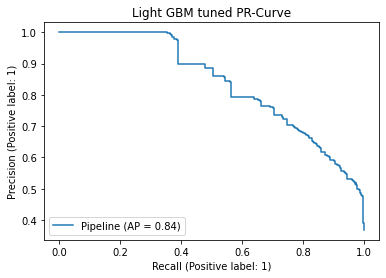

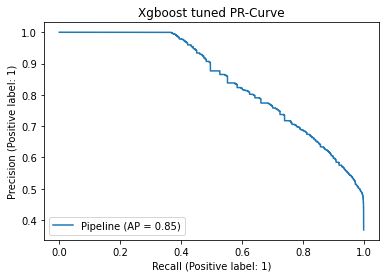

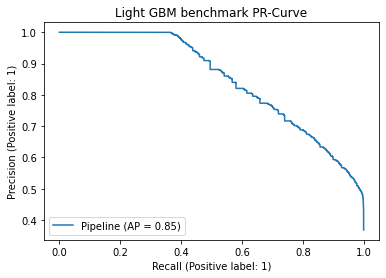

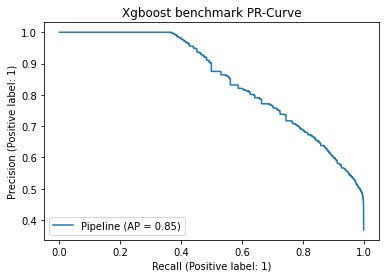

In [50]:
list_model = []
list_f05 = []
list_precision = []
list_recall = []
fit_time = []
score_time = []

for name, model in prediction_models:        
        
        start = time.time()
        model.fit(X_train, y_train)
        stop = time.time()
        fit_time.append(round((stop-start), 3))

        start = time.time()        
        y_pred = model.predict(X_test)
        stop = time.time()
        score_time.append(round((stop-start), 3))

        PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
        plt.title(f'{name} PR-Curve')

        list_model.append(name)
        list_f05.append(round(fbeta_score(y_test, y_pred, beta=0.5), 3))
        list_precision.append(round(precision_score(y_test, y_pred), 3))
        list_recall.append(round(recall_score(y_test, y_pred), 3))

pd.DataFrame({
    'model': list_model,
    'f.05 score': list_f05,
    'precision' : list_precision,
    'recall' : list_recall,
    'fit time': fit_time,
    'score time': score_time
}).sort_values('f.05 score', ascending=False)   

From the table above, we can see tuned Light GBM has the highest f0.5 score and precision, but the recall score is pretty bad. It also has the worst PR-curve. So, I don't think the model is ideal for our problems. I decide to use the tuned Xgboost as our final model because it has more balance in precision and recall score. We need to remember that both error types will cost us something, so we can't sacrifice too much on one side.

## Feature Importances

In [51]:
binary_cols = list(transformer.transformers_[0][1][1].get_feature_names())
onehot_cols = list(transformer.transformers_[1][1].get_feature_names_out())
remainder_cols = list(X.columns[transformer.transformers_[2][2]])

feature_name = binary_cols + onehot_cols + remainder_cols


In [52]:
feature_importances = pd.DataFrame({
    'features' : feature_name,
    'importances': tuned_xgboost['algo'].feature_importances_
})

feature_importances.sort_values('importances', ascending=False).head(10)

,features,importances
17,deposit_type_Non Refund,0.748128
36,required_car_parking_spaces,0.058549
14,market_segment_Online TA,0.030884
16,deposit_type_No Deposit,0.026075
33,previous_cancellations,0.016908
21,customer_type_Transient,0.014394
10,market_segment_Corporate,0.014151
37,total_of_special_requests,0.011688
6,0_6,0.011033
7,0_7,0.010303


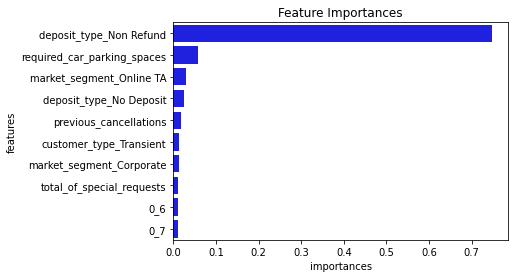

In [53]:
top10_features = feature_importances.sort_values('importances', ascending=False).head(10)

sns.barplot(data = top10_features, y= 'features', x='importances', ci=0, color='blue')
plt.title('Feature Importances')
plt.show()

We can see that deposit_type_Non Refund is the most important feature for our Xgboost model, followed by required_car_parking_spaces and market_segment_Online TA. From the graph, it is clear that deposit_type_Non Refund is much more important than other features combined. This analysis in-line with our EDA, which is the **non refund** deposit type has the highest canceled bookings proportion. The canceled bookings also tend to **not** require parking spaces.

## Modeling with Feature Selection

We will try to do feature selection based on the feature importances of the Xgboost model and compare the result of different number of features.

In [54]:
list_thresh = []
list_n_features = []
list_f05 = []
list_precision = []
list_recall = []
list_fit_time = []
list_score_time = []

# select features using threshold of feature importances
thresholds = [0, 0.001, 0.0015, 0.003, 0.005, 0.01, 0.02, 0.03]

for thresh in thresholds:
    
    pipe_model= Pipeline([
        ('preprocessing', transformer),
        ('scaler', MinMaxScaler()),
        ('feature_selection', SelectFromModel(tuned_xgboost['algo'], threshold=thresh)),
        ('algo', tuned_xgboost['algo'])          
    ])
    
    start = time.time()
    pipe_model.fit(X_train, y_train)
    stop = time.time()
    fit_time = stop-start

    start = time.time()
    y_pred = pipe_model.predict(X_test)
    stop = time.time()
    score_time = stop-start

    predictions = [round(value) for value in y_pred]

    n_features = len(pipe_model['algo'].feature_importances_)
    f05 = fbeta_score(y_test, predictions, beta=0.5)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)

    list_thresh.append(thresh)
    list_n_features.append(n_features)
    list_f05.append(round(f05,3))
    list_precision.append(round(precision,3))
    list_recall.append(round(recall,3))
    list_fit_time.append(round(fit_time,3))
    list_score_time.append(round(score_time,3))

pd.DataFrame({
    'Thresh': list_thresh,
    'Number of Features': list_n_features,
    'f0.5 score': list_f05,
    'precision': list_precision,
    'recall': list_recall,
    'fit time' : list_fit_time,
    'score time': list_score_time
    
}).sort_values('f0.5 score', ascending=False)

,Thresh,Number of Features,f0.5 score,precision,recall,fit time,score time
0,0.0000,38,0.754,0.772,0.688,5.433,0.141
1,0.0010,30,0.753,0.773,0.684,5.063,0.136
2,0.0015,24,0.750,0.765,0.692,4.766,0.140
3,0.0030,19,0.749,0.769,0.680,4.667,0.131
4,0.0050,12,0.742,0.779,0.624,4.200,0.132
5,0.0100,10,0.742,0.780,0.621,4.128,0.128
6,0.0200,4,0.704,0.991,0.326,3.995,0.125
7,0.0300,3,0.703,0.991,0.325,3.351,0.123


As we can see, the f0.5 score is better with larger number of features and it keeps dropping with smaller number of features. The feature selection might be more useful if we're dealing with a large number of features. Since we only have 38 features, if we reduce half the number of features to 19, the training time only improves a little. Then, it might be better to use all the features to have better performance. So, our final model will be the tuned Xgboost without feature selection.

## Final Model


In [55]:
final_model = tuned_xgboost
final_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imp_binary',
                                                  Pipeline(steps=[('constant',
                                                                   SimpleImputer(fill_value='Other',
                                                                                 strategy='constant')),
                                                                  ('binary',
                                                                   BinaryEncoder(handle_unknown='indicator'))]),
                                                  ['country']),
                                                 ('one hot',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=6),
                                                  ['market_segment',...
                               eval_metric=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=350,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=70, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=0, reg_alpha=0, ...))])

### Model Algorithm

Xgboost or Exreme Gradient Boosting is an optimized algorithm of Gradient Boosting specially designed to improve speed and performance. Boosting itself is an ensemble method to build a strong classifier from several weak classifiers in sequential order. The main goal of Gradient Boosting is to minimize the loss function by adding weak learners using a gradient descent optimization algorithm. 

Let's talk about Gradient Boosting algorithm first. There are 3 main components:
- **Loss Function**: The role of the loss function is to estimate how best is the model in making predictions with the given data. This could vary depending on the type of the problem. 
- **Weak Learner**: Weak learner is one that classifies the data so poorly when compared to random guessing. The weak learners are mostly decision trees, but other models can be used in GBM.
- **Additive Model**: It is an iterative and sequential process in adding the decision trees one step at a time. Each iteration should reduce the value of loss function. A fixed number of trees are added, or training stops once loss reaches an acceptable level or no longer improves on an external validation dataset.

Next, we will discuss about Xgboost optimized features to improve performance:
- **Regularized Learning**: Xgboost is a more regularized form of Gradient Boosting. Xgboost uses advanced regularization (L1 & L2), which improves model generalization capabilities. 
- **Early Stopping (auto-pruning)**: early stopping or tree pruning is a way to reduce overfitting. This means that a node was trimmed if the gain improvement is below a fixed threshold.
- **Missing values treatment**: whenever Xgboost find a missing value during prediction, a default direction is created at every node of the tree. The optimal default directions are learned from the training data. 





Let's look into our final model results in more details.

In [56]:
y_pred = final_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85     13199
           1       0.77      0.69      0.73      7695

    accuracy                           0.81     20894
   macro avg       0.80      0.78      0.79     20894
weighted avg       0.81      0.81      0.81     20894



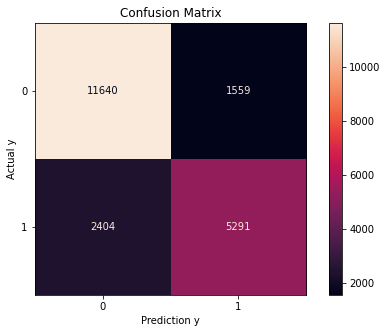

In [57]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ConfusionMatrixDisplay.from_estimator(final_model, X_test, y_test, cmap='rocket', ax=ax)

plt.xlabel('Prediction y')
plt.ylabel('Actual y')
plt.title('Confusion Matrix')
plt.show()

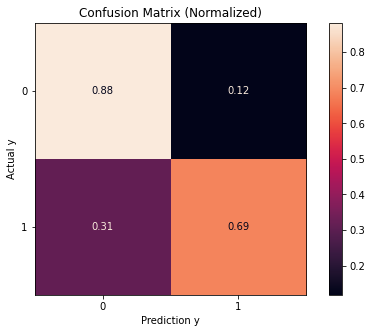

In [58]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ConfusionMatrixDisplay.from_estimator(final_model, X_test, y_test, normalize='true', cmap='rocket', ax=ax)

plt.xlabel('Prediction y')
plt.ylabel('Actual y')
plt.title('Confusion Matrix (Normalized)')
plt.show()

### Model Implementation

Based on the classification report, if we use this model to predict the canceled booking, then we can predict 69% of bookings that are actually canceled and we can avoid overbooking for 88% of bookings that are actually not canceled.

Every time our model predicts a booking is canceled, it has 77% chance of being True. There is still 12% chance of our model predicting a booking is canceled but is actually not canceled (False Positive Rate) which can cause overbooked.

To make it easier to understand, we can look at the normalized confusion matrix. I will try to explain the normalized confusion matrix with this example. Let's say there are 200 bookings for a hotel (100 canceled and 100 not canceled). 
- The top left number in the confusion matrix represent True Negative Rate.<br>
    Which means out of 100 **actually** not canceled bookings, our model can **predict** 88 not canceled bookings correctly.
- The top right number  in the confusion matrix represent False Positive Rate. <br>
    Which means out of 100 **actually** not canceled bookings, our model **predict** 12 of them as canceled bookings.
- The bottom left number in the confusion matrix represent False Negative Rate.<br>
    Which means out of 100 **actually** canceled bookings, our model **predict** 31 of them as not canceled bookings.
- The bottom right number in the confusion matrix represent True Positive Rate.<br> 
    Which means out of 100 **actually** canceled bookings, our model can **predict** 69 canceled bookings correctly.

<br>
Let's continue the example, let's say the hotel has 200 rooms. A room that is filled with customer can generate 125 USD for the hotel revenue. If a room is empty, it will cost the hotel 25 USD and if a room is overbooked, it will cost the hotel 100 USD for customer compensation. For this example, we will assume that the hotel can find substitute customers for every predicted canceled rooms.

---
Without the model, we will assume all bookings are canceled.

- predicted number of canceled bookings = 200
- actual number of canceled bookings = 100

Because the actual number of canceled bookings is smaller than the predicted one, it means we have overbooked rooms in our hotel. The number of overbooked rooms equal to the difference between the actual and predicted number of canceled bookings.

- filled rooms = 200 x 125 USD = 25.000 USD
- empty rooms = 0 x -25 USD = 0 USD
- overbooked rooms = 100 x -100 USD = -10.000 USD

net revenue = 25.000 - 0 - 10.000 = **15.000 USD**

(This calculation hasn't counted the cost for potential loss of future revenue and bad reputation)

---

With our model, we will overbook the rooms based on the model canceled predictions

- predicted number of canceled bookings = 81
- actual number of canceled bookings = 100

Because the actual number of canceled bookings is bigger than the predicted one, it means we have empty rooms in our hotel. The number of empty rooms equal to the difference between the actual and predicted number of canceled bookings.

- filled rooms = 181 x 125 USD = 22.625 USD
- empty rooms = 19 x -25 USD = -475 USD
- overbooked rooms = 0 x -50 USD = 0 USD

net revenue = 12.500 - 475 - 0 = **22.150 USD**

(There are no upset customers, which is good for the hotel reputation)

---

**Increase in revenue = 22.150 - 15.000 = 7.150 USD**

% Increase = 7.150 / 15.000 x 100 = 47,67%

Based on the example, our model can increase **47,67%** of the hotel's net revenue while still maintaining good reputation for the hotel (no overbook rooms).


### Model limitation

There are some limitations in our model
- **Lack of data**<br>
    There are 2 type of limitation: lack of data and lack of **good** data. There is a saying that goes 'AI can only be as smart as the quality of data'. In this case, our model can only predict accurately if the prediction data is within the range of the training data. For example, most of the country in the training data come from Europe, so our model might be biased for country outside Europe.
- **Lack of interpretability** <br>
    A complex ensemble model usually perform better in discovering underlying patterns and increasing accuracy. Even though our model can predict accurate results, it is hard for us to explain how our model arrived at the conclusion. 
- **Computational and Time limitation** <br>
    Hyperparameter tuning is a crucial part for improving our model performance, but some models require sufficient amount of computing power and time. For example, we only try 50 iterations in randomized search for xgboost, so our model hasn't improved much. 





## Conclusion

From the results, we can summarize our final model using Xgboost:
- Top 3 most important features are **deposit_type_Non Refund**, **required_car_parking_spaces, and market_segment_Online TA**
- **Precision** = 0.77  which mean the chance of our model can predict a canceled booking correctly are **77%**.
- **Recall** =  0.69 which mean out of 100% of actually canceled bookings, our model can predict **69%** of them.
- **False Positive Rate** (actually not canceled, predicted canceled) = **12%**
- **False Negative Rate** (actually canceled, predicted not canceled) = **31%**
- Implementation of model can **increase  47,67% of the hotel's net revenue**
- Model limitation = **lack of data, lack of interpretability, computational and time limitation**

## Recommendation

Some recommendations to improve our model:
- Collecting more good data to make our model more robust. A lot of country has less than 10 data, so the data is highly imbalanced.
- Adding new features that might be related to canceled bookings, for example: the the date of arrival (to analyze the trend), number of days between booking and arrival, Average Daily Rate (ADR), etc.
- If we have sufficient high-quality data, we might try to use a simple single-type model to increase the interpretability of our model. Usually, a simple model can do the job if the data quality is good.
- Try different combination of feature selection and feature engineering, for example changing the base model for selecting feature importance or use SHAP.



## Save Model

In [59]:
# # Save model
# import pickle

# pickle.dump(final_model, open('booking_prediction_model.sav', 'wb'))

In [60]:
# # Load model
# model = pickle.load(open('booking_prediction_model.sav', 'rb'))
# print(classification_report(y_test, model.predict(X_test)))